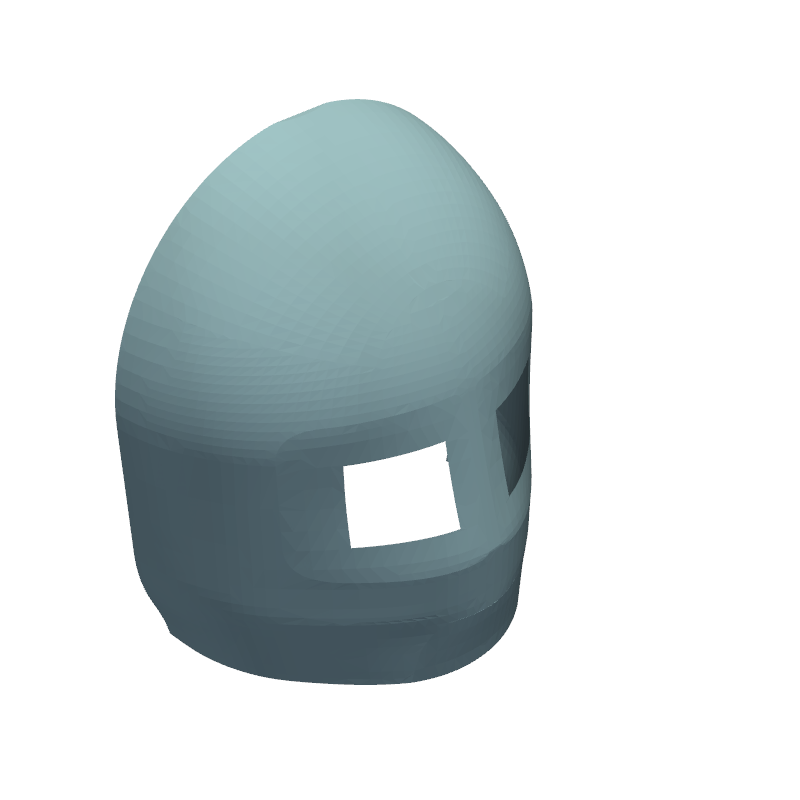

In [69]:
import numpy as np
from mayavi import mlab
import trimesh
import scipy.io as sio
from bfieldtools.mesh_conductor import MeshConductor
from bfieldtools.coil_optimize import optimize_streamfunctions

faceloop = trimesh.load_mesh(r"single.STL")
rotation_matrix = np.array(
    [
    [ 1,  0,  0, 0],
    [ 0,  1,  0, 0],
    [ 0,  0,  1, 0],
    [ 0,  0,  0, 1]
    ]
)
faceloop.apply_transform(rotation_matrix)
faceloop.vertices /= 1000
coil = MeshConductor(mesh_obj=faceloop, fix_normals=True)
MeshConductor.plot_mesh(coil)

In [70]:
B0_map = sio.loadmat(r"map_data/B0_map_valid_qmj.mat")

b_k = B0_map['B0_data'].flatten() * 5 / 1e6
x_k = B0_map['X'].flatten()
y_k = B0_map['Y'].flatten() + 0.05
z_k = B0_map['Z'].flatten()
target_points = np.stack([x_k, y_k, z_k], axis=1)

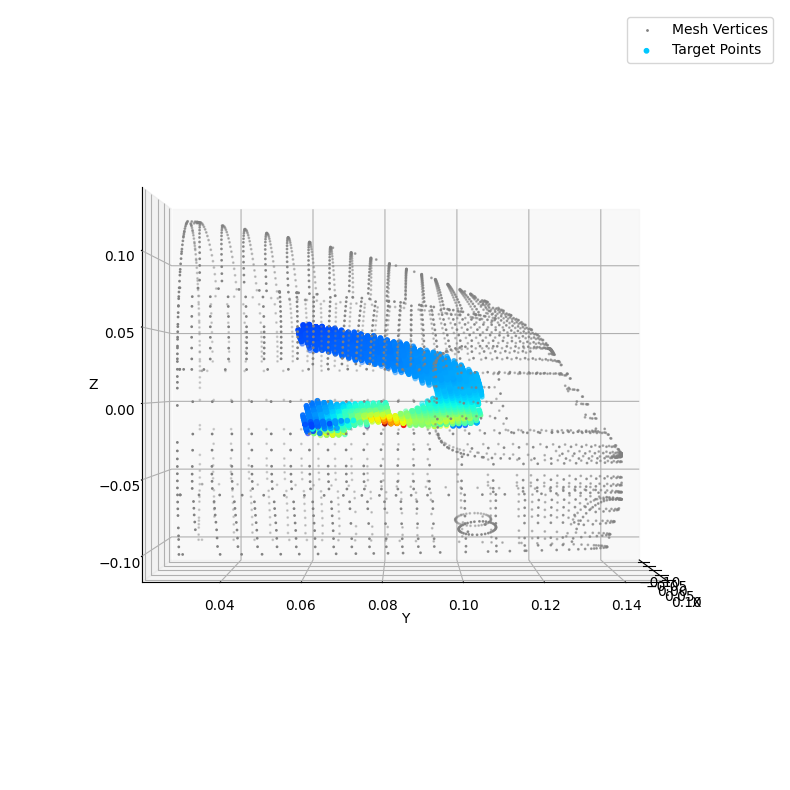

In [71]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# faceloop.vertices[:, 2] += 0.3
mesh_verts = faceloop.vertices

ax.scatter(mesh_verts[:, 0], mesh_verts[:, 1], mesh_verts[:, 2], s=1, c='gray', label='Mesh Vertices')

ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], s=10 , c = b_k, cmap = 'jet', label='Target Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0,azim=0)
ax.legend()
plt.tight_layout()
plt.show()

In [72]:
target_field = b_k.reshape(-1, 1) 
target_abs_error = np.ones_like(target_field) * 1e-7
sample_rate = 50
target_points = target_points[::sample_rate]
target_field = target_field[::sample_rate]
target_abs_error = target_abs_error[::sample_rate]

target_spec = {
    "coupling": coil.B_coupling(target_points)[:,2,:], 
    "abs_error": target_abs_error,
    "target": target_field,
}

Computing magnetic field coupling matrix, 2712 vertices by 151 target points... took 0.17 seconds.


In [73]:
coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="OSQP"
)


Computing the inductance matrix...
Computing self-inductance matrix using rough quadrature (degree=2).              For higher accuracy, set quad_degree to 4 or more.
Estimating 26532 MiB required for 2712 by 2712 vertices...
Computing inductance matrix in 20 chunks (231737 MiB memory free),              when approx_far=True using more chunks is faster...
Computing triangle-coupling matrix
Inductance matrix computation took 13.59 seconds.
Passing problem to solver...
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) 6月 22 11:59:02 下午: Your problem has 2461 variables, 302 constraints, and 0 parameters.
(CVXPY) 6月 22 11:59:02 下午: It is compliant with the following grammars: DCP, DQCP
(CVXPY) 6月 22 11:59:02 下午: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) 6月 22 11:59:02 下午: CVXPY will first compile your pro

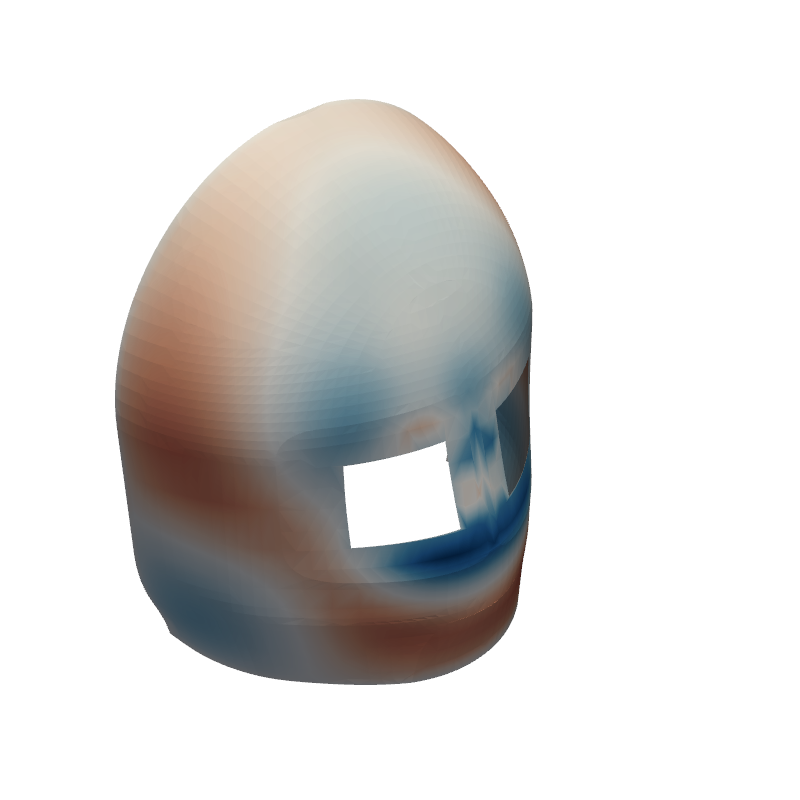

In [74]:
s = coil.s.plot(ncolors=64)

<class 'pyvista.plotting.plotter.Plotter'>


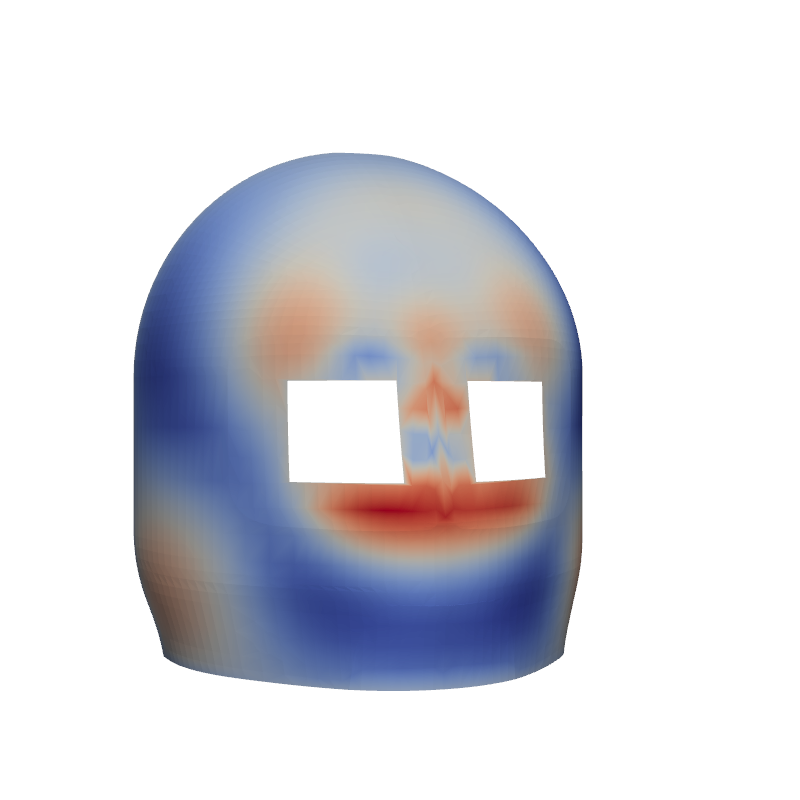

In [78]:
print(type(s))
s.add_mesh(s.mesh, cmap="coolwarm", show_scalar_bar=False)  
s.view_vector([1, 3, 0])   
s.show()

In [79]:
from bfieldtools.line_conductor import LineConductor

Processing contour, value: -10.013809361795047
Processing contour, value: -4.235307509249534
Processing contour, value: 1.5431943432959798
Processing contour, value: 7.321696195841492
Processing contour, value: 13.100198048387009
Processing contour, value: 18.878699900932517


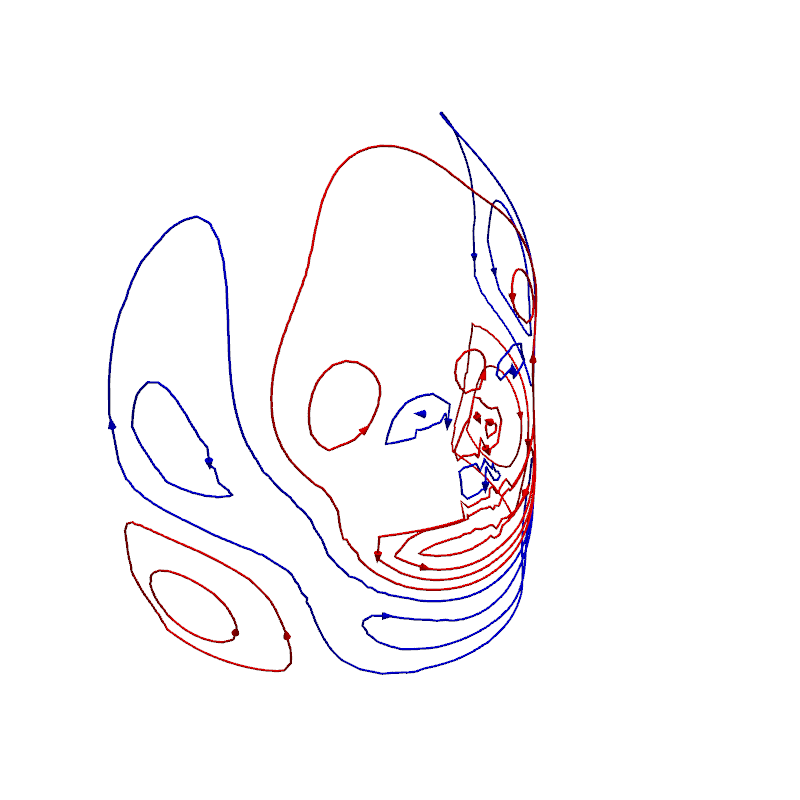

In [88]:
loops = coil.s.discretize(N_contours=6)
l = loops.plot_loops(tube_radius = 0.0005)

In [89]:
from bfieldtools.line_conductor import LineConductor, simplify_contour

def safe_simplify(self, min_edge=1e-2, angle_threshold=2e-2, smooth=True):
    valid_loops = []
    for e in self.entities:
        coords = e.discrete(self.vertices)
        simplified = simplify_contour(coords, min_edge, angle_threshold, smooth)
        if simplified is not None and len(simplified) >= 1:
            valid_loops.append(simplified)
    return LineConductor(valid_loops)

# 替换原方法
LineConductor.simplify = safe_simplify


In [90]:
l_1 = loops.simplify(min_edge=1e-4, angle_threshold=2e-2,smooth=True)

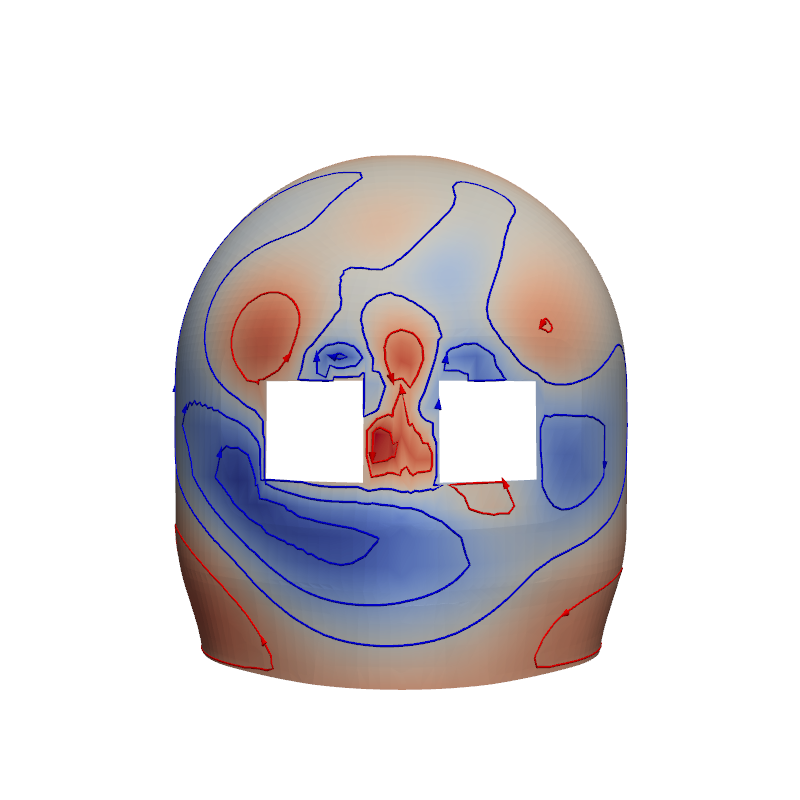

In [56]:
l.add_mesh(s.mesh,cmap='coolwarm', show_scalar_bar=False)  # 设置为 jet 色图
l.view_vector([0, 30, 0]) 
l.show()

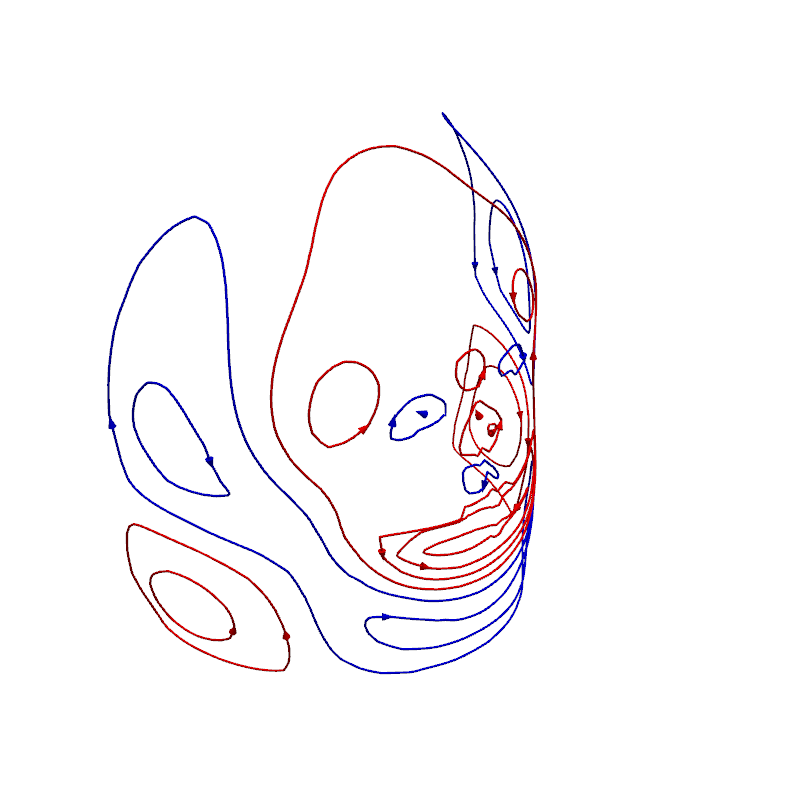

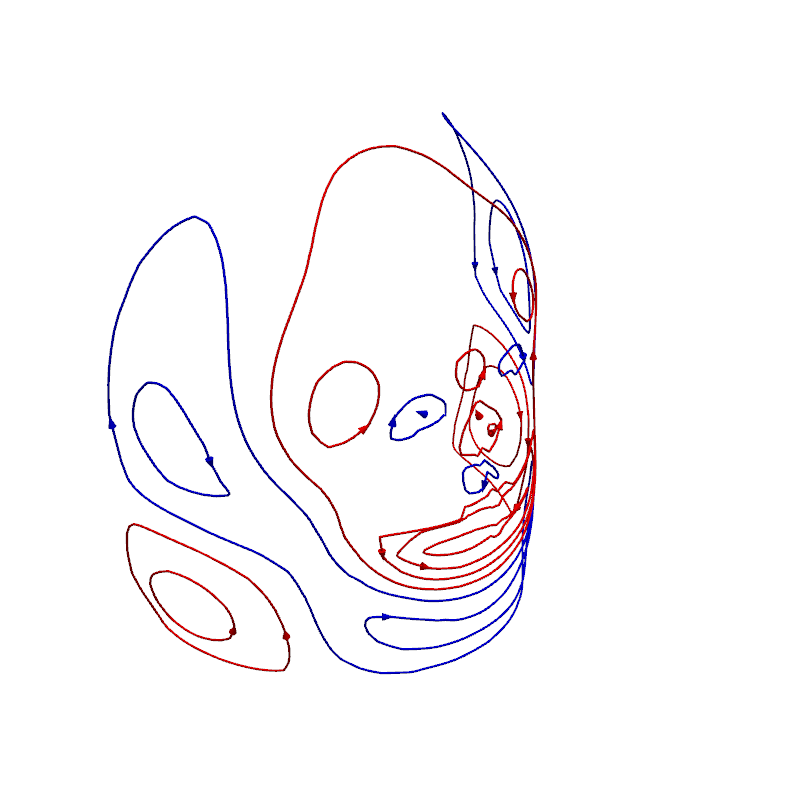

In [91]:
plotter = l_1.plot_loops(tube_radius = 0.0005)
plotter.view_vector([0,0,0])

plotter.show()

In [92]:
all_loops = [e.discrete(l_1.vertices) for e in l_1.entities]
with open("coil_loops_v2.obj", "w") as f:
    vertex_offset = 1
    for loop in all_loops:
        for v in loop:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        f.write("l " + " ".join(str(i) for i in range(vertex_offset, vertex_offset + len(loop))) + "\n")
        vertex_offset += len(loop)
